# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

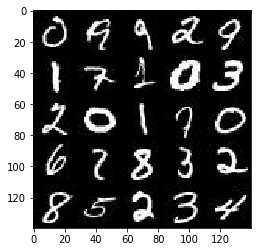

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

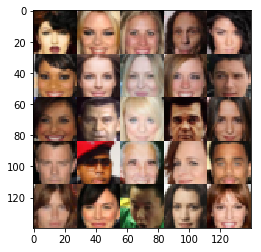

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [24]:
import math

def discriminator_layer_first(images, out_depth, kernel, stride, leaky_alpha=0.2):
    # Input layer is 28x28x3
    in_size = (28, 28, 3)
    
    size = (math.ceil(in_size[0] / stride),
            math.ceil(in_size[1] / stride),
            out_depth)
    
    layer = tf.layers.conv2d(images,
                             size[2],
                             kernel,
                             strides=stride,
                             padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    layer = tf.maximum(leaky_alpha * layer, layer)
    
    return layer, size

def discriminator_layer_i(prev_layer, in_size, training, kernel, stride, normalize, leaky_alpha=0.2):
    size = (math.ceil(in_size[0] / stride),
            math.ceil(in_size[1] / stride),
            in_size[2] * 2)
    
    layer = tf.layers.conv2d(prev_layer,
                             size[2],
                             kernel,
                             strides=stride,
                             padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    if normalize:
        layer = tf.layers.batch_normalization(layer, training=training)
    layer = tf.maximum(leaky_alpha * layer, layer)
    
    return layer, size
    
def discriminator_layer_last(prev_layer, in_size, training, training_keep_prob=0.75):
    flat = tf.reshape(prev_layer, (-1, in_size[0]*in_size[1]*in_size[2]))
    logits = tf.layers.dense(flat, 1)
    
    if training:
        logits = tf.nn.dropout(logits, training_keep_prob)
    
    return logits

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28
        layer, size = discriminator_layer_first(images,
                                                out_depth=64,
                                                kernel=5,
                                                stride=2,
                                                leaky_alpha=0.2)
        # now: 14x14
        
        layer, size = discriminator_layer_i(layer,
                                            size,
                                            training=True,
                                            kernel=5,
                                            stride=2,
                                            normalize=True,
                                            leaky_alpha=0.2)
        # now: 7x7
        
        layer, size = discriminator_layer_i(layer,
                                            size,
                                            training=True,
                                            kernel=3,
                                            stride=2,
                                            normalize=True,
                                            leaky_alpha=0.2)
        # now: 4x4

        # Flatten it
        logits = discriminator_layer_last(layer,
                                          size,
                                          training=True,
                                          training_keep_prob=0.7)
        
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator_layer_first(z, training, out_depth, normalize, leaky_alpha=0.2):
    size = (7, 7, out_depth)
    
    # First fully connected layer
    layer = tf.layers.dense(z, size[0]*size[1]*size[2])

    # Reshape it to start the convolutional stack
    layer = tf.reshape(layer, (-1, *size))
    if normalize:
        layer = tf.layers.batch_normalization(layer, training=training)
    layer = tf.maximum(leaky_alpha * layer, layer)
    
    return layer, size

def generator_layer_i(prev_layer, in_size, training, kernel, stride, normalize, leaky_alpha=0.2):
    size = (in_size[0] * stride,
            in_size[1] * stride,
            math.ceil(in_size[2] / stride))
    
    layer = tf.layers.conv2d_transpose(prev_layer,
                                       size[2],
                                       kernel,
                                       strides=stride,
                                       padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
    if normalize:
        layer = tf.layers.batch_normalization(layer, training=training)
    layer = tf.maximum(leaky_alpha * layer, layer)
    
    return layer, size
    
def generator_layer_last(prev_layer, in_size, out_channel_dim, kernel, stride):
    size = (in_size[0] * stride,
            in_size[1] * stride,
            out_channel_dim)
    
    logits = tf.layers.conv2d_transpose(prev_layer,
                                        out_channel_dim,
                                        kernel,
                                        strides=stride,
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    return logits, size
    
    
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer, size = generator_layer_first(z,
                                            is_train,
                                            out_depth=512,
                                            normalize=True,
                                            leaky_alpha=0.2)
        # now: 7x7
        
        layer, size = generator_layer_i(layer,
                                        size,
                                        is_train,
                                        kernel=5,
                                        stride=2,
                                        normalize=True,
                                        leaky_alpha=0.2)
        # now: 14x14
        
        layer, size = generator_layer_i(layer,
                                        size,
                                        is_train,
                                        kernel=5,
                                        stride=2,
                                        normalize=True,
                                        leaky_alpha=0.2)
        # now: 28x28
        
        # Output layer
        logits, size = generator_layer_last(layer,
                                            size,
                                            out_channel_dim=out_channel_dim,
                                            kernel=5,
                                            stride=1)
        # now: 28x28
        
        assert size[0] == 28, "size[0] != 28: %r" % size[0]
        assert size[1] == 28, "size[1] != 28: %r" % size[1]
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Config
    print_every = 20
    show_every = 100
    show_n_images = 25
    g_opt_times_per_batch = 3
    
    # Aliases
    out_channel_dim = data_shape[3]
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)    
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # As suggested by @rahul_ahuja on the forum:
                # works better when pixels within range [-1, 1]
                batch_images *= 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learn_rate: learning_rate})
                for g_opt_i in range(g_opt_times_per_batch):
                    _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                                   input_z: batch_z,
                                                   learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)
        
        print("=== final output ===")
        show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6599... Generator Loss: 0.2603
Epoch 1/2... Discriminator Loss: 2.8410... Generator Loss: 0.3053
Epoch 1/2... Discriminator Loss: 2.5473... Generator Loss: 0.3176
Epoch 1/2... Discriminator Loss: 2.3860... Generator Loss: 0.3141
Epoch 1/2... Discriminator Loss: 2.1655... Generator Loss: 0.3197


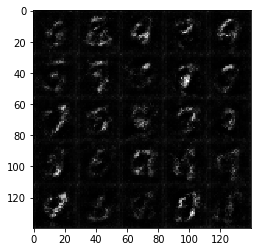

Epoch 1/2... Discriminator Loss: 1.8738... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 2.0914... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.8547... Generator Loss: 0.4004
Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 0.4055
Epoch 1/2... Discriminator Loss: 1.6315... Generator Loss: 0.4155


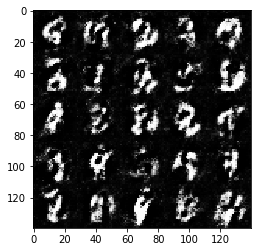

Epoch 1/2... Discriminator Loss: 1.6257... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.6482... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.5379


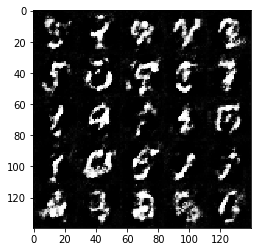

Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 0.4341
Epoch 1/2... Discriminator Loss: 1.7529... Generator Loss: 0.3346
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.5847... Generator Loss: 0.7187


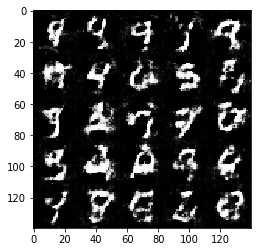

Epoch 1/2... Discriminator Loss: 1.6525... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 1.6266... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 1.6222... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.6721


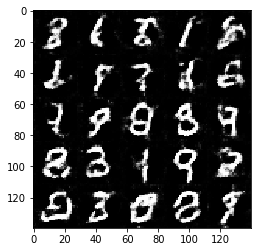

Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.5342... Generator Loss: 0.4628
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.4893
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.4506


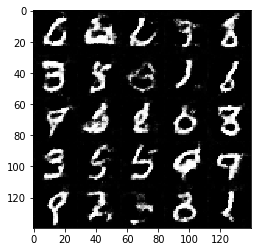

Epoch 1/2... Discriminator Loss: 1.6008... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.5387... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 1.5881... Generator Loss: 0.4114
Epoch 1/2... Discriminator Loss: 1.6477... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.6307... Generator Loss: 0.4698


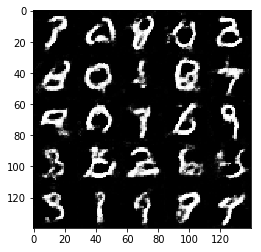

Epoch 1/2... Discriminator Loss: 1.6439... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.6097... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.5339... Generator Loss: 0.5018


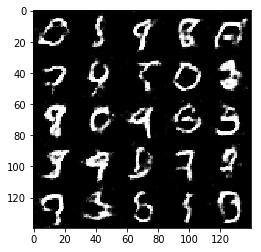

Epoch 1/2... Discriminator Loss: 1.5679... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.5387
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.4696
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.5524


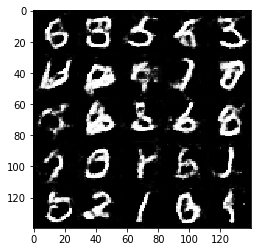

Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.5466
Epoch 2/2... Discriminator Loss: 1.7634... Generator Loss: 0.3486
Epoch 2/2... Discriminator Loss: 1.5801... Generator Loss: 0.3910


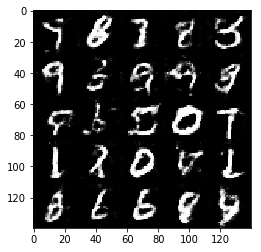

Epoch 2/2... Discriminator Loss: 1.5830... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.6754... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 1.5638... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 0.4676
Epoch 2/2... Discriminator Loss: 1.5414... Generator Loss: 0.6042


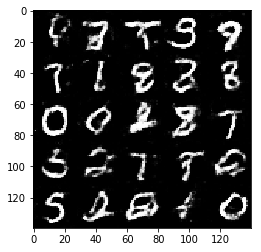

Epoch 2/2... Discriminator Loss: 1.6426... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 1.6121... Generator Loss: 0.5783
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.5722... Generator Loss: 0.5232
Epoch 2/2... Discriminator Loss: 1.6041... Generator Loss: 0.6667


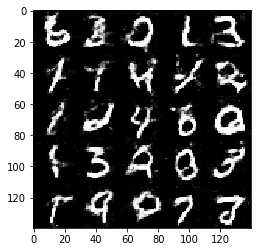

Epoch 2/2... Discriminator Loss: 1.5550... Generator Loss: 0.5432
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 1.5453... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.5991... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.5228


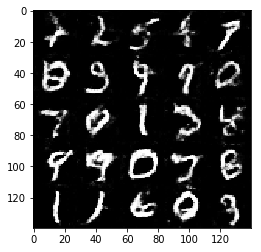

Epoch 2/2... Discriminator Loss: 1.5821... Generator Loss: 0.4452
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.6150
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.6592... Generator Loss: 0.4937
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 0.5159


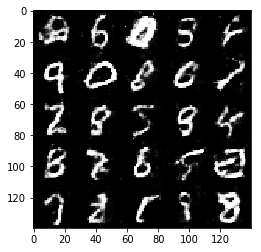

Epoch 2/2... Discriminator Loss: 1.5846... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.6039... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.7693... Generator Loss: 0.3679
Epoch 2/2... Discriminator Loss: 1.5322... Generator Loss: 0.6176


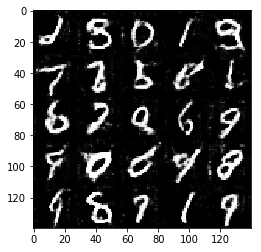

Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.6885... Generator Loss: 0.4792
Epoch 2/2... Discriminator Loss: 1.6286... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 1.5217... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.5340... Generator Loss: 0.6459


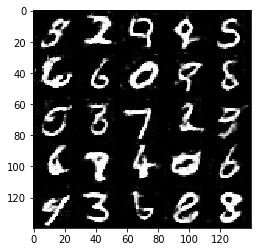

Epoch 2/2... Discriminator Loss: 1.5737... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.5606... Generator Loss: 0.5081
Epoch 2/2... Discriminator Loss: 1.6250... Generator Loss: 0.4760
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.6333... Generator Loss: 0.4087


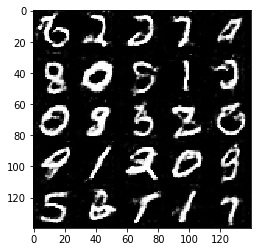

Epoch 2/2... Discriminator Loss: 1.5539... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.5938... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.6014... Generator Loss: 0.5210
Epoch 2/2... Discriminator Loss: 1.5937... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 1.6302... Generator Loss: 0.4543


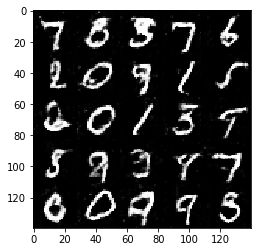

Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 1.6885... Generator Loss: 0.3802
Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 0.5593
=== final output ===


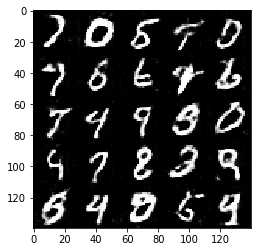

In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.5868... Generator Loss: 0.1471
Epoch 1/1... Discriminator Loss: 3.5637... Generator Loss: 0.2149
Epoch 1/1... Discriminator Loss: 3.2185... Generator Loss: 0.2715
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 3.2811
Epoch 1/1... Discriminator Loss: 2.5753... Generator Loss: 0.3481


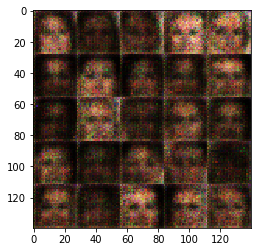

Epoch 1/1... Discriminator Loss: 2.2384... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.8875... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.9388... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.7979... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.7981... Generator Loss: 0.5185


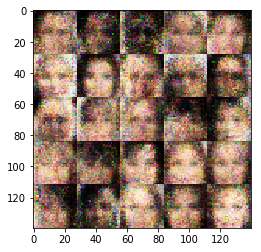

Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.7010


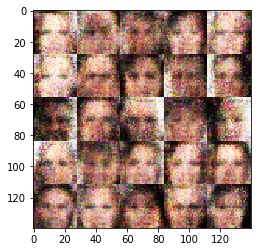

Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.6307


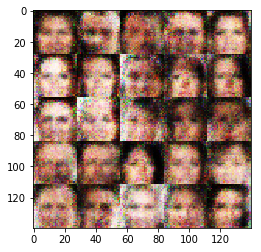

Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6551


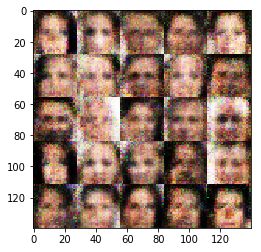

Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5715


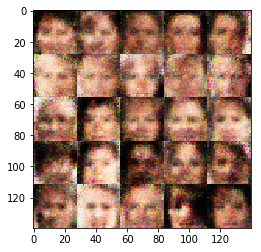

Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7400


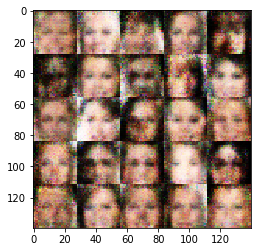

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5982


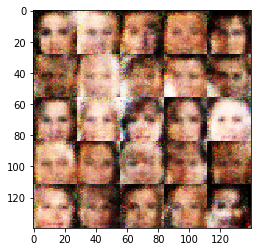

Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6886


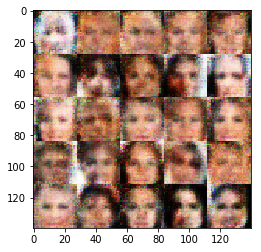

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5882


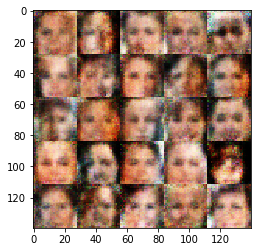

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5875


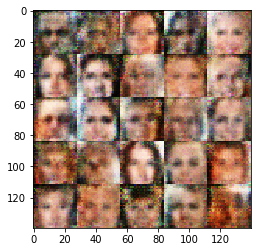

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6604


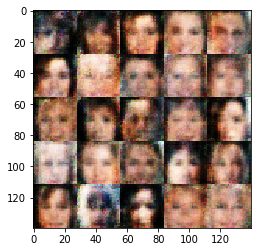

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5918


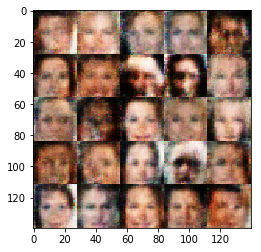

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6840


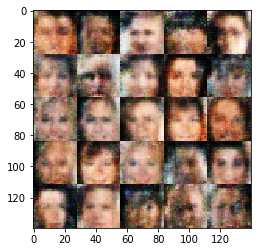

Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6765


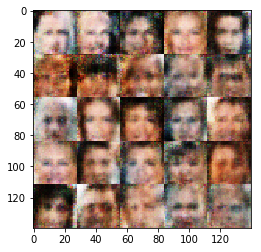

Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6723
=== final output ===


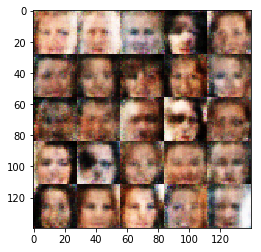

In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.